In [80]:
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, AIMessage
from pptx import Presentation

In [81]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


In [83]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
import os
from langchain_openai import ChatOpenAI

# Set API key
os.environ["OPENAI_API_KEY"] = "your-api-key"

llm = ChatOpenAI(model="gpt-4o-mini" , temperature = 0.7 , timeout = 30)

In [85]:
from langgraph.graph import Graph
from pptx import Presentation
from pptx.util import Pt

In [93]:
# Step 1: Extract Subtopics
def get_subtopics(state: PresentationState):
    prompt = f"List 5 key subtopics for a presentation on '{state.topic}'."
    response = llm.predict(prompt)
    subtopics = response.split("\n")[:5]  # Extract subtopics
    return PresentationState(topic=state.topic, subtopics=subtopics)

In [94]:
# Step 2: Generate Slide Content
def generate_content(state: PresentationState):
    content = {}

    for sub in state.subtopics:
        prompt = f"Write professional slide content for the subtopic '{sub}' under '{state.topic}'."
        content[sub] = llm.predict(prompt)

    return PresentationState(topic=state.topic, subtopics=state.subtopics, content=content)

In [95]:
# Step 3: Generate PowerPoint
def generate_pptx(state: PresentationState):
    prs = Presentation()
    slide_layout = prs.slide_layouts[1]  # Title and Content Layout

    # Cover Slide
    slide = prs.slides.add_slide(prs.slide_layouts[0])
    slide.shapes.title.text = state.topic
    slide.shapes.placeholders[1].text = "An AI-generated presentation"

    # Create slides for each subtopic
    for subtopic, text in state.content.items():
        slide = prs.slides.add_slide(slide_layout)
        slide.shapes.title.text = subtopic
        slide.shapes.placeholders[1].text = text

    # Save the presentation
    pptx_filename = f"{state.topic.replace(' ', '_')}.pptx"
    prs.save(pptx_filename)

    return PresentationState(topic=state.topic, subtopics=state.subtopics, content=state.content, pptx_filename=pptx_filename)


In [111]:
from pydantic import BaseModel

# ✅ Define State Schema using Pydantic
class PresentationState(BaseModel):
    topic: str
    subtopics: list[str] = []
    content: dict[str, str] = {}
    pptx_filename: str = ""

In [112]:
graph = StateGraph(PresentationState)  # Fix: Use Pydantic Model

In [113]:
# ✅ Create LangGraph Workflow with Correct Schema

graph.add_node("get_subtopics", get_subtopics)
graph.add_node("generate_content", generate_content)
graph.add_node("generate_pptx", generate_pptx)

In [114]:
# Define Workflow Sequence
graph.set_entry_point("get_subtopics")
graph.add_edge("get_subtopics", "generate_content")
graph.add_edge("generate_content", "generate_pptx")

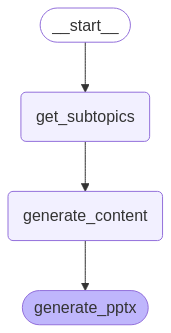

In [115]:
# Compile the Workflow
compiled_graph = graph.compile()
compiled_graph

In [116]:
# Get User Input
topic = input("Enter the topic for the presentation: ")

# Run the Workflow
output = compiled_graph.invoke(PresentationState(topic=topic))

# Confirm PPTX Generation
print(f"PPTX Generated: {output.pptx_filename}")

AttributeError: 'AddableValuesDict' object has no attribute 'pptx_filename'